# qnlp-tutorial

We go through the basics of DisCoPy and QNLP: how to draw circuit diagrams, how to evaluate them, how to learn functors from grammar to circuits.

## 1. Drawing cooking recipes

An **object** `Ob` can be thought of as a basic ingredient in a recipe, it is defined only by its name, e.g. `'egg'`, `'sentence'`, `'qubit'`, etc.
A **type** `Ty` is simply a sequence of objects, i.e. a bunch of ingredients side by side, e.g. `Ty('egg', 'qubit')` represents an egg next to a qubit.
Types form a monoid with **tensor** `@` as product and the empty type `Ty()` as unit.
For example:

In [1]:
from discopy import Ob, Ty

egg, white, yolk = Ty('egg'), Ty('white'), Ty('yolk')

assert egg.objects == [Ob('egg')]
assert white @ yolk == Ty(Ob('white'), Ob('yolk'))

assert egg @ Ty() == egg == Ty() @ egg
assert egg @ (white @ yolk) == (egg @ white) @ yolk

Once we have defined some types, we can draw a **box** `Box` with some types as **domain** `dom` and **codomain** `cod`.

We can compose boxes both in parallel with `@` and in sequence with `>>`.

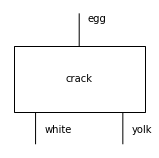

In [2]:
from discopy import Box

crack = Box('crack', dom=egg, cod=white @ yolk)

crack.draw(figsize=(2, 2))

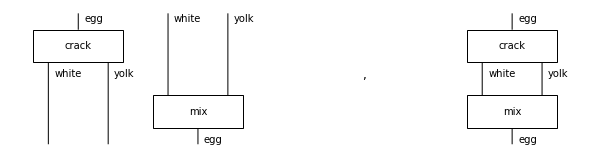

In [3]:
from discopy import drawing

mix = Box('mix', white @ yolk, egg)

crack_tensor_mix = crack @ mix
crack_then_mix = crack >> mix

drawing.equation(crack_tensor_mix, crack_then_mix, space=2, symbol=', ', figsize=(8, 2))

We can draw the identity `Id` for a type, i.e. just some parallel wires. Composing with an identity does nothing. Tensoring with the identity of the empty type, i.e. the empty diagram `Id(Ty())`, does nothing either.

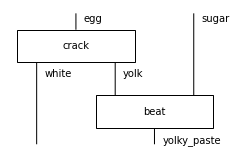

In [4]:
from discopy import Id

assert crack >> Id(white @ yolk) == crack == Id(egg) >> crack
assert crack @ Id(Ty()) == crack == Id(Ty()) @ crack

sugar, yolky_paste = Ty('sugar'), Ty('yolky_paste')
beat = Box('beat', yolk @ sugar, yolky_paste)

crack_then_beat = crack @ Id(sugar) >> Id(white) @ beat

crack_then_beat.draw(figsize=(3, 2))

We can swap wires using `Swap` boxes.

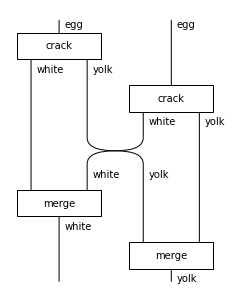

In [5]:
from discopy import Swap

merge = lambda x: Box('merge', x @ x, x)

crack_two_eggs = crack @ crack\
    >> Id(white) @ Swap(yolk, white) @ Id(yolk)\
    >> merge(white) @ merge(yolk)

crack_two_eggs.draw(figsize=(3, 4))

**Exercise:** Draw your favorite cooking recipe as a diagram. You'll want to keep your ingredients in order if you want to avoid swapping them.

**Further reading:** Check out Pawel's blogpost [Crema di mascarpone and diagrammatic reasoning](https://graphicallinearalgebra.net/2015/05/06/crema-di-mascarpone-rules-of-the-game-part-2-and-diagrammatic-reasoning/).

**Exercise (harder):** Define a function that takes a number `n` and returns the recipe of a tiramisu with `n` layers of crema di mascarpone and savoiardi.

## 2. Drawing quantum circuits

A **pure** quantum `Circuit` is nothing more than a recipe with qubits as ingredients, cooking step is called a `QuantumGate` and they obey an important rule: they always leave the number of ingredients intact.

H @ Id(1) >> CX


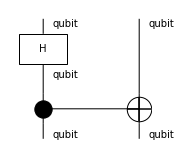

In [19]:
from discopy.quantum import Id, qubit, H, CX

circuit = H @ Id(qubit) >> CX
print(circuit)
circuit.draw(figsize=(2, 2), draw_type_labels=True, margins=(.1,.1))

A pure quantum circuit can be evaluated as a `Tensor` object, which holds a `numpy.ndarray` such that `tensor.array.shape == tensor.dom @ tensor.cod`. The evaluation of a composition is given by matrix multiplication, the evaluation of a tensor is given by the Kronecker product. In practice, this is computed using `numpy.tensordot` and `numpy.moveaxis`.

In [7]:
print(H.eval())
print(CX.eval())

Tensor(dom=Dim(2), cod=Dim(2), array=[0.70710678, 0.70710678, 0.70710678, -0.70710678])
Tensor(dom=Dim(2, 2), cod=Dim(2, 2), array=[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j])


In [8]:
assert circuit.eval() == H.eval() @ Id(qubit).eval() >> CX.eval()

circuit.eval().array

array([[[[ 0.70710678+0.j,  0.        +0.j],
         [ 0.        +0.j,  0.70710678+0.j]],

        [[ 0.        +0.j,  0.70710678+0.j],
         [ 0.70710678+0.j,  0.        +0.j]]],


       [[[ 0.70710678+0.j,  0.        +0.j],
         [ 0.        +0.j, -0.70710678+0.j]],

        [[ 0.        +0.j,  0.70710678+0.j],
         [-0.70710678+0.j,  0.        +0.j]]]])

In [9]:
import numpy as np

assert np.all(
    (H >> H).eval().array == H.array.dot(H.array))
assert np.all(
    (H @ H).eval().array == np.moveaxis(np.tensordot(
    H.array, H.array, 0), range(4), [0, 2, 1, 3]))
assert np.all(
    circuit.eval().array == np.tensordot(H.array, CX.array, 1))

Another important rule is that a pure quantum circuit is reversible, i.e. it evaluates to a unitary matrix. The reverse of a circuit is called its **dagger**, written with the list reverse operator `[::-1]`. 

CX >> H @ Id(1)


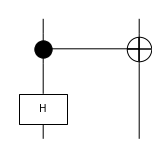

In [18]:
print(circuit[::-1])
circuit[::-1].draw(figsize=(2, 2), margins=(.1,.1))

In [11]:
assert (CX >> CX[::-1]).eval() == Id(qubit ** 2).eval()
assert np.all(np.isclose((H >> H[::-1]).eval(), Id(qubit).eval()))

Matrix multiplication is fun and all, but that's not really what quantum computers do. To simulate the quantum state that the circuit produces, we need to pre-compose it with a `Ket`, i.e. we need to initialise some qubits before we apply our circuit.
In our example `circuit`, the resulting state is the so called Bell state $\frac{1}{\sqrt{2}} (|00\rangle + |11\rangle)$.

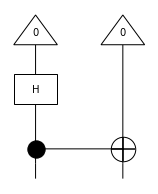

In [54]:
from discopy.quantum import Ket

(Ket(0, 0) >> circuit).draw(figsize=(2, 2.5))

In [55]:
(Ket(0, 0) >> circuit).eval()

Tensor(dom=Dim(1), cod=Dim(2, 2), array=[0.70710678+0.j, 0.    +0.j, 0.    +0.j, 0.70710678+0.j])

To compute the probability of a particular measurement result, we need to post-compose our circuit with a `Bra`, the dagger of `Ket`, then apply the Born rule.

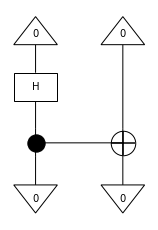

0.4999999999999999


In [78]:
from discopy.quantum import Bra

experiment = Ket(0, 0) >> circuit >> Bra(0, 0)
experiment.draw(figsize=(2, 3))
amplitude = experiment.eval().array[0]
probability = abs(amplitude) ** 2
print(probability)

If we want to get the probability distribution over bitstrings, we need to leave the realm of purity to consider **mixed** quantum circuits with both `bit` and `qubit` ingredients.
The `Measure` box has `dom=qubit` and `cod=bit`.
Another example of a mixed box is `Discard` which computes a partial trace over a qubit.
Mixed circuits cannot be evaluated as a unitary matrix anymore.
Instead, whenever the circuit is mixed `circuit.eval()` outputs a `CQMap`, a `numpy.ndarray` with axes for the classical and quantum dimensions of the circuit.

In [79]:
from discopy.quantum import Measure, Discard

print(Discard().eval())
print(Measure().eval())

CQMap(dom=Q(Dim(2)), cod=CQ(), array=[1., 0., 0., 1.])
CQMap(dom=Q(Dim(2)), cod=C(Dim(2)), array=[1, 0, 0, 0, 0, 0, 0, 1])


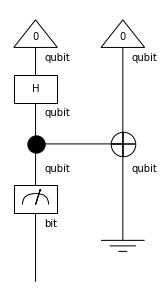

CQMap(dom=CQ(), cod=C(Dim(2)), array=[0.5+0.j, 0.5+0.j])

In [80]:
(Ket(0, 0) >> circuit >> Measure() @ Discard()).draw(figsize=(2, 4))
(Ket(0, 0) >> circuit >> Measure() @ Discard()).eval()

Note that as for diagrams of cooking recipes, we need to introduce swaps in order to apply two-qubit gates to non-adjacent qubits. These swaps have no physical meaning, they are just an artefact of drawing circuits in 2 dimensions rather than 4. Indeed, we can forget about swaps by compiling our planar diagram into the graph-based data structure of $\mathrm{t|ket\rangle}$.

In [81]:
from discopy.quantum import SWAP

circuit.to_tk()

tk.Circuit(2).H(0).CX(0, 1)

In [82]:
(SWAP >> circuit >> SWAP).to_tk()

tk.Circuit(2).H(1).CX(1, 0)

We can execute our circuit on a $\mathrm{t|ket\rangle}$ backend (simulator or hardware) by passing it as a parameter to `eval`.

In [83]:
from pytket.backends.ibm import AerBackend

aer = AerBackend()

(circuit >> Measure() @ Discard()).eval(backend=aer)

Tensor(dom=Dim(1), cod=Dim(2), array=[0.48925781, 0.51074219])

**Exercise:** Run your own Bell experiment on quantum hardware! You can use IBMQ machines for free, if you're ready to wait.

**Exercise:** Draw a circuit that evaluates to the GHZ state $\frac{1}{\sqrt{2}} (|000\rangle + |111\rangle)$.

**Exercise (harder):** Define a function that takes a number `n` and returns a circuit for the generalised GHZ state $\frac{1}{\sqrt{2}} (|0...0\rangle + |1...1\rangle)$.

## 3. Drawing grammatical structure

So far we've learnt how to draw diagrams of cooking recipes and how to evaluate quantum circuits. Now we're gonna see that diagrams can represent the grammatical structure of a sentence.

The ingredients are grammatical types: `n` for noun, `s` for sentence, etc. Each ingredient has left and right adjoints `n.l` and `n.r`. For example we have the type for intransitive verbs `n.r @ s` which reads "take a noun on your left and give a sentence".

The cooking steps are of two kinds: words and cups. Words have no inputs, they output their own type. Cups have no outputs, they take two types `left` and `right` as inputs such that `left.r == right`. If you can take a bunch of words and apply cups till you have only `s` left, then well-done, you formed a grammatical sentence.

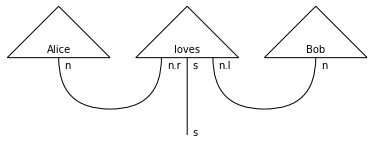

In [69]:
from discopy import Ty, Id, Word, Cup, pregroup

n, s = Ty('n'), Ty('s')

Alice = Word("Alice", n)
loves = Word("loves", n.r @ s @ n.l)
Bob = Word("Bob", n)

grammar = Cup(n, n.r) @ Id(s) @ Cup(n.l, n)

sentence = Alice @ loves @ Bob >> grammar
pregroup.draw(sentence, figsize=(5, 5))